# 大作业要求

1.大作业以2-3人为一组完成，提交材料包括PPT（最后一次课展示成果）+ 可运行的jupyter notebook，标注相应的注释并给出运行结果 + 最终的大作业报告（正文不超过5页word/pdf，附录可选不限，需组内各成员单独提交，内容为本人在课程大作业中的贡献以及对大作业问题的思考) + 提交包含分工情况及组内各成员工作量占比的表格。分工表格需组内所有成员签字确认；

2.禁止抄袭，发现雷同，所有雷同提交分数除以2；

3.写清楚大作业中的贡献和创新点，若使用开源代码和论文中的方法，在报告中必须注明（不可作为本人创新点），发现不标注引用，分数除以2。

最后一次课展示说明： 1.样例 PPT例子：https://www.sohu.com/a/166633625_642762 2.展示时间限制：展示时间为6分钟讲+2分钟同学助教老师自由提问

大作业报告：强调个人对问题的理解，以及贡献，建议增加在提问反馈之后的改进结果。

最终评分为:30%展示评分+70%大作业报告

# 问题描述

深度神经网络通常采用独立同分布(Independent-Identically)的假设进行训练，即假设测试数据分布与训练数据分布相似。然而，当用于实际任务时，这一假设并不成立，导致其性能显著下降。虽然这种性能下降对于产品推荐等宽容性大的应用是可以接受的，但在医学等宽容性小的领域使用此类系统是危险的，因为它们可能导致严重事故。理想的人工智能系统应尽可能在分布外（Out-of-Distribution）的情况下有较强的分部外泛化能力。而提高分布外泛化的关键点，就是如何让模型学习到数据中的causal feature。

一个简单的例子：以猫狗二分类为例，如果训练集中所有狗都在草地上，所有的猫都在沙发上，而测试集中所有的狗在沙发上，所有的猫在草地上，那么模型在没有测试集信息的情况下，很有可能根据训练集的信息把草地和狗联系在了一起，沙发和猫联系在了一起，当模型在测试集上测试时将会把在沙发上的狗误认为是猫。

# 数据集(Colored MNIST)

Colored MNIST是MNIST手写数字分类数据集的变体，包含有三个不同的域，每个域包含一组不相交的红色或绿色数字并分别保存为train1.pt, train2.pt, test.pt。该数据集总共包含60000个样本。 

在该数据集中，训练集和测试集之间存在Out-of-Distribution情况，color feature和数字产生了spurious correlation，即虚假的因果关系。从直观上来说，数字的形状为causal feature，数字的颜色为non-causal feature。

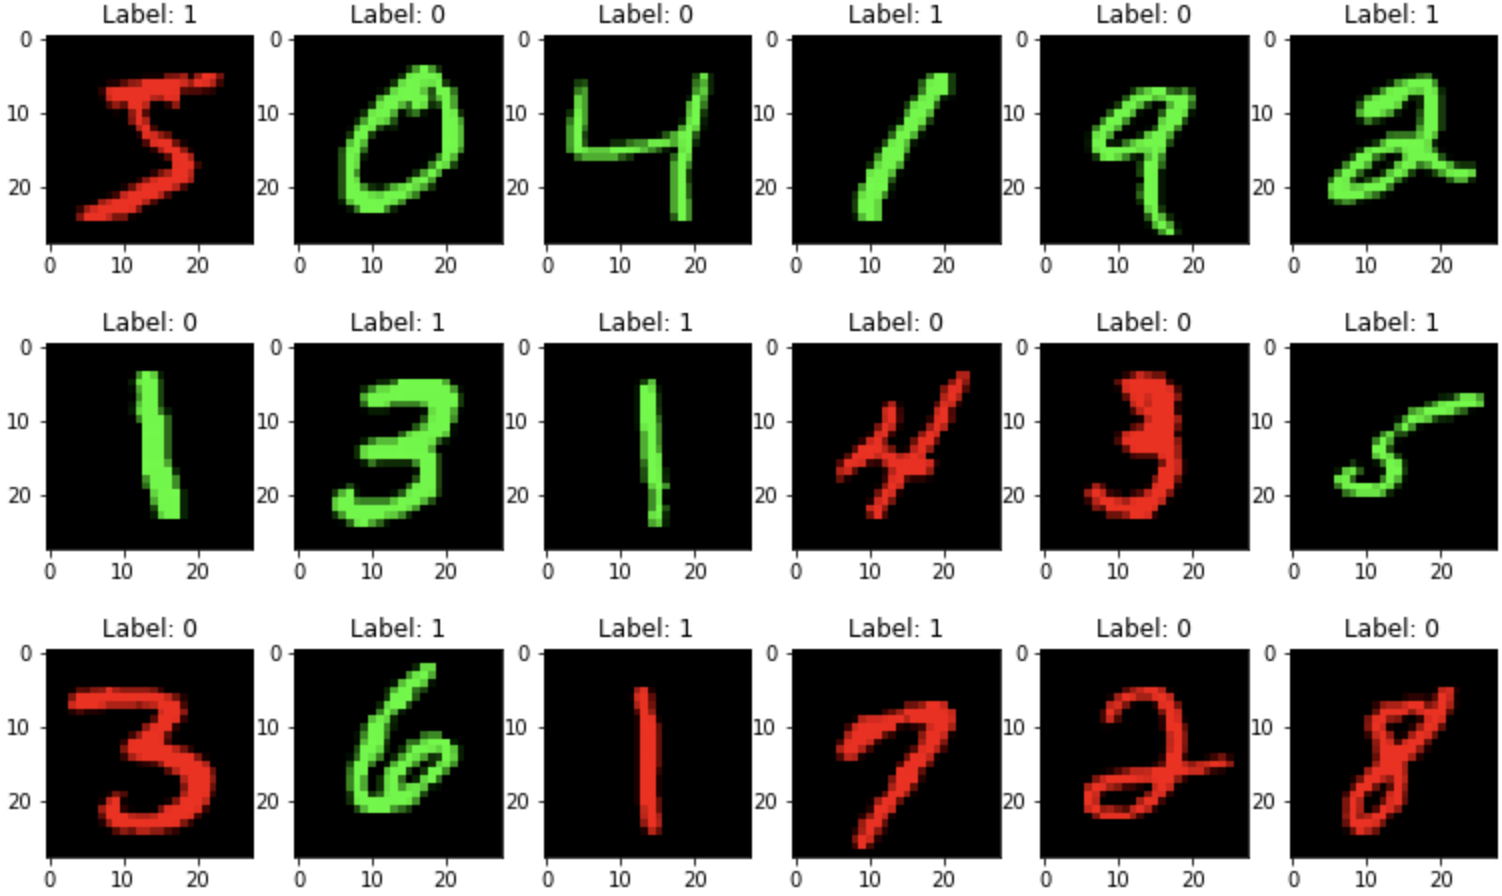

# Colored MNIST数据集

In [156]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils


def color_grayscale_arr(arr, red=True):
    """Converts grayscale image to either red or green"""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    arr = np.reshape(arr, [h, w, 1])
    if red:
        arr = np.concatenate([arr,
                              np.zeros((h, w, 2), dtype=dtype)], axis=2)
    else:
        arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype),
                              arr,
                              np.zeros((h, w, 1), dtype=dtype)], axis=2)
    return arr


class ColoredMNIST(datasets.VisionDataset):
    """
  Colored MNIST dataset for testing IRM. Prepared using procedure from https://arxiv.org/pdf/1907.02893.pdf

  Args:
    root (string): Root directory of dataset where ``ColoredMNIST/*.pt`` will exist.
    env (string): Which environment to load. Must be 1 of 'train1', 'train2', 'test', or 'all_train'.
    transform (callable, optional): A function/transform that  takes in an PIL image
      and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
      target and transforms it.
  """

    def __init__(self, root='./new_data', env='train1', transform=None, target_transform=None):
        super(ColoredMNIST, self).__init__(root, transform=transform,
                                           target_transform=target_transform)

        self.prepare_colored_mnist()
        if env in ['train1', 'train2', 'test']:
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
        elif env == 'all_train':
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', 'train1.pt')) + \
                                     torch.load(os.path.join(self.root, 'ColoredMNIST', 'train2.pt'))
        else:
            raise RuntimeError(f'{env} env unknown. Valid envs are train1, train2, test, and all_train')

    def __getitem__(self, index):
        """
    Args:
        index (int): Index

    Returns:
        tuple: (image, target) where target is index of the target class.
    """
        img, target ,color= self.data_label_tuples[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target,color

    def __len__(self):
        return len(self.data_label_tuples)

    def prepare_colored_mnist(self):
        colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
        if os.path.exists(os.path.join(colored_mnist_dir, 'train1.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'train2.pt')) \
                and os.path.exists(os.path.join(colored_mnist_dir, 'test.pt')):
            print('Colored MNIST dataset already exists')
            return

        print('Preparing Colored MNIST')
        train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)

        train1_set = []
        train2_set = []
        test_set = []
        for idx, (im, label) in enumerate(train_mnist):
            if idx % 10000 == 0:
                print(f'Converting image {idx}/{len(train_mnist)}')
            im_array = np.array(im)

            # Assign a binary label y to the image based on the digit
            binary_label = 0 if label < 5 else 1

            # Flip label with 25% probability
            if np.random.uniform() < 0.25:
                binary_label = binary_label ^ 1

            # Color the image either red or green according to its possibly flipped label
            color_red = binary_label == 0

            # Flip the color with a probability e that depends on the environment
            if idx < 20000:
                # 20% in the first training environment
                if np.random.uniform() < 0.2:
                    color_red = not color_red
            elif idx < 40000:
                # 10% in the first training environment
                if np.random.uniform() < 0.1:
                    color_red = not color_red
            else:
                # 90% in the test environment 
                if np.random.uniform() < 0.9:
                    color_red = not color_red
            # color_red is true when the picture is red
            colored_arr = color_grayscale_arr(im_array, red=color_red)

            if idx < 20000:
                # original dataset
                # train1_set.append((Image.fromarray(colored_arr), binary_label))
                # with the color
                train1_set.append((Image.fromarray(colored_arr), binary_label,color_red))
            elif idx < 40000:
                # original dataset
                # train2_set.append((Image.fromarray(colored_arr), binary_label))
                # with the number label dataset
                train2_set.append((Image.fromarray(colored_arr), binary_label,color_red))
            else:
                # original dataset
                # test_set.append((Image.fromarray(colored_arr), binary_label))
                # with the number label dataset
                test_set.append((Image.fromarray(colored_arr), binary_label,color_red))

            # Debug
            # print('original label', type(label), label)
            # print('binary label', binary_label)
            # print('assigned color', 'red' if color_red else 'green')
            # print('the number is', label)
            # plt.imshow(colored_arr)
            # plt.show()
            # break

        # dataset_utils.makedir_exist_ok(colored_mnist_dir)
        torch.save(train1_set, os.path.join(colored_mnist_dir, 'train1.pt'))
        torch.save(train2_set, os.path.join(colored_mnist_dir, 'train2.pt'))
        torch.save(test_set, os.path.join(colored_mnist_dir, 'test.pt'))

In [157]:
ColoredMNIST()

Colored MNIST dataset already exists


Dataset ColoredMNIST
    Number of datapoints: 20000
    Root location: ./new_data

# ▶︎▶︎▶︎基础部分

### 1. 设计ColoredMNIST数据二分类的因果图，合理即可。并基于后门准则，推导𝑃(𝑦|𝑑𝑜(𝑥)) 【提示：因果图可以为E->X, E->Y, X->Y, E为环境，比如颜色】

见报告

### 2. 在ColoredMNIST数据上实现基于后门准则的因果推理算法，训练神经网络，提升模型预测准确度。

# 1. 读取数据

读取数据集

In [246]:

from torch.utils.data import DataLoader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_1_dataset = ColoredMNIST(root='./new_data', env='train1', transform=transform)  
train_2_dataset = ColoredMNIST(root='./new_data', env='train2', transform=transform) 
# train_all_dataset =  ColoredMNIST(root='./new_data', env='all_train', transform=transform) 
test_dataset = ColoredMNIST(root='./new_data', env='test', transform=transform)
# train_dataset = ColoredMNIST(root='./data', env='train1')
# test_dataset = ColoredMNIST(root='./data', env='test')
train_1_loader = DataLoader(train_1_dataset, batch_size=64, shuffle=True)
train_2_loader = DataLoader(train_2_dataset, batch_size=64, shuffle=True)
# train_all_loader = DataLoader(train_all_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Colored MNIST dataset already exists
Colored MNIST dataset already exists
Colored MNIST dataset already exists


In [247]:
label_0 = 0
label_1 = 0
for i in range (20000):
    if train_1_dataset.__getitem__(i)[1]==0:
        label_0 += 1
    else:
        label_1 += 1
print('train1 has '+str(label_0)+' red and label 0 pictures')
print('train1 has '+str(label_1)+' red and label 1 pictures' )

train1 has 10112 red and label 0 pictures
train1 has 9888 red and label 1 pictures


In [248]:
red = 0
green = 0
for i in range (20000):
    if train_1_dataset.__getitem__(i)[2]==1:
        red += 1
    else:
        green += 1
print('train1 has '+str(red)+' red and red pictures')
print('train1 has '+str(green)+' red and green pictures' )

train1 has 10046 red and red pictures
train1 has 9954 red and green pictures


处理数据集train1，方法是根据后们准则，将label0对应的红色和绿色图片调整到相同的数量（方法是切割数据集，也就是下采样），label1对应的红色和绿色图片也要调整到一致

In [159]:
red_label_0 = 0
red_label_1 = 0
green_label_0 =0
green_label_1 =0
for i in range (20000):
    if train_1_dataset.__getitem__(i)[2]==1 and train_1_dataset.__getitem__(i)[1]==0:
        red_label_0 += 1
    elif train_1_dataset.__getitem__(i)[2]==1 and train_1_dataset.__getitem__(i)[1]==1:
        red_label_1 += 1
    elif train_1_dataset.__getitem__(i)[2]==0 and train_1_dataset.__getitem__(i)[1]==0:
        green_label_0 += 1
    else:
        green_label_1 += 1
print('train1 has '+str(red_label_0)+' red and label 0 pictures')
print('train1 has '+str(red_label_1)+' red and label 1 pictures' )
print('train1 has '+str(green_label_0)+' green and label 0 pictures')
print('train1 has '+str(green_label_1)+' green and label 1 pictures' )
new_train_1_dataset = train_2_dataset
label_0_number = min(green_label_0,red_label_0)
label_1_number = min(green_label_1,red_label_1)
print(label_0_number)
print(label_1_number)
red_label_0_num = 0
red_label_1_num = 0
green_label_0_num = 0
green_label_1_num = 0
new_train_1_dataset.data_label_tuples.clear()
# print(len(new_train_1_dataset))
for i in range(20000):
    if train_1_dataset.__getitem__(i)[2]==1 and train_1_dataset.__getitem__(i)[1]==0:
        if red_label_0_num <= label_0_number:
            new_train_1_dataset.data_label_tuples.append(train_1_dataset.data_label_tuples[i])
            red_label_0_num += 1
        else:
            continue
    if train_1_dataset.__getitem__(i)[2]==0 and train_1_dataset.__getitem__(i)[1]==0:
        if green_label_0_num <= label_0_number:
            new_train_1_dataset.data_label_tuples.append(train_1_dataset.data_label_tuples[i])
            green_label_0_num += 1
        else:
            continue
    if train_1_dataset.__getitem__(i)[2]==1 and train_1_dataset.__getitem__(i)[1]==1:
        if red_label_1_num <= label_1_number:
            new_train_1_dataset.data_label_tuples.append(train_1_dataset.data_label_tuples[i])
            red_label_1_num += 1
        else:
            continue
    if train_1_dataset.__getitem__(i)[2]==0 and train_1_dataset.__getitem__(i)[1==1]:
        if green_label_1_num <= label_1_number:
            new_train_1_dataset.data_label_tuples.append(train_1_dataset.data_label_tuples[i])
            green_label_1_num += 1
        else:
            continue
red_label_0 = 0
red_label_1 = 0
green_label_0 =0
green_label_1 =0
for i in range (len(new_train_1_dataset)):
    if new_train_1_dataset.__getitem__(i)[2]==1 and new_train_1_dataset.__getitem__(i)[1]==0:
        red_label_0 += 1
    elif new_train_1_dataset.__getitem__(i)[2]==1 and new_train_1_dataset.__getitem__(i)[1]==1:
        red_label_1 += 1
    elif new_train_1_dataset.__getitem__(i)[2]==0 and new_train_1_dataset.__getitem__(i)[1]==0:
        green_label_0 += 1
    else:
        green_label_1 += 1
print('new train1 has '+str(red_label_0)+' red and label 0 pictures')
print('new train1 has '+str(red_label_1)+' red and label 1 pictures' )
print('new train1 has '+str(green_label_0)+' green and label 0 pictures')
print('new train1 has '+str(green_label_1)+' green and label 1 pictures' )

train1 has 8119 red and label 0 pictures
train1 has 1927 red and label 1 pictures
train1 has 1993 green and label 0 pictures
train1 has 7961 green and label 1 pictures
1993
1927
new train1 has 1994 red and label 0 pictures
new train1 has 1927 red and label 1 pictures
new train1 has 1993 green and label 0 pictures
new train1 has 1928 green and label 1 pictures


In [160]:
train_1_dataset = ColoredMNIST(root='./new_data', env='train1', transform=transform)  
train_2_dataset = ColoredMNIST(root='./new_data', env='train2', transform=transform) 

Colored MNIST dataset already exists
Colored MNIST dataset already exists


处理数据集train2

In [161]:
red_label_0 = 0
red_label_1 = 0
green_label_0 =0
green_label_1 =0
for i in range (20000):
    if train_2_dataset.__getitem__(i)[2]==1 and train_2_dataset.__getitem__(i)[1]==0:
        red_label_0 += 1
    elif train_2_dataset.__getitem__(i)[2]==1 and train_2_dataset.__getitem__(i)[1]==1:
        red_label_1 += 1
    elif train_2_dataset.__getitem__(i)[2]==0 and train_2_dataset.__getitem__(i)[1]==0:
        green_label_0 += 1
    else:
        green_label_1 += 1
print('train2 has '+str(red_label_0)+' red and label 0 pictures')
print('train2 has '+str(red_label_1)+' red and label 1 pictures' )
print('train2 has '+str(green_label_0)+' green and label 0 pictures')
print('train2 has '+str(green_label_1)+' green and label 1 pictures' )
new_train_2_dataset = train_1_dataset
label_0_number = min(green_label_0,red_label_0)
label_1_number = min(green_label_1,red_label_1)
print(label_0_number)
print(label_1_number)
red_label_0_num = 0
red_label_1_num = 0
green_label_0_num = 0
green_label_1_num = 0
new_train_2_dataset.data_label_tuples.clear()
# print(len(new_train_1_dataset))
for i in range(20000):
    if train_2_dataset.__getitem__(i)[2]==1 and train_2_dataset.__getitem__(i)[1]==0:
        if red_label_0_num <= label_0_number:
            new_train_2_dataset.data_label_tuples.append(train_2_dataset.data_label_tuples[i])
            red_label_0_num += 1
        else:
            continue
    if train_2_dataset.__getitem__(i)[2]==0 and train_2_dataset.__getitem__(i)[1]==0:
        if green_label_0_num <= label_0_number:
            new_train_2_dataset.data_label_tuples.append(train_2_dataset.data_label_tuples[i])
            green_label_0_num += 1
        else:
            continue
    if train_2_dataset.__getitem__(i)[2]==1 and train_2_dataset.__getitem__(i)[1]==1:
        if red_label_1_num <= label_1_number:
            new_train_2_dataset.data_label_tuples.append(train_2_dataset.data_label_tuples[i])
            red_label_1_num += 1
        else:
            continue
    if train_2_dataset.__getitem__(i)[2]==0 and train_2_dataset.__getitem__(i)[1==1]:
        if green_label_1_num <= label_1_number:
            new_train_2_dataset.data_label_tuples.append(train_2_dataset.data_label_tuples[i])
            green_label_1_num += 1
        else:
            continue
red_label_0 = 0
red_label_1 = 0
green_label_0 =0
green_label_1 =0
for i in range (len(new_train_2_dataset)):
    if new_train_2_dataset.__getitem__(i)[2]==1 and new_train_2_dataset.__getitem__(i)[1]==0:
        red_label_0 += 1
    elif new_train_2_dataset.__getitem__(i)[2]==1 and new_train_2_dataset.__getitem__(i)[1]==1:
        red_label_1 += 1
    elif new_train_2_dataset.__getitem__(i)[2]==0 and new_train_2_dataset.__getitem__(i)[1]==0:
        green_label_0 += 1
    else:
        green_label_1 += 1
print('new train2 has '+str(red_label_0)+' red and label 0 pictures')
print('new train2 has '+str(red_label_1)+' red and label 1 pictures' )
print('new train2 has '+str(green_label_0)+' green and label 0 pictures')
print('new train2 has '+str(green_label_1)+' green and label 1 pictures' )

train2 has 8991 red and label 0 pictures
train2 has 954 red and label 1 pictures
train2 has 1047 green and label 0 pictures
train2 has 9008 green and label 1 pictures
1047
954
new train2 has 1048 red and label 0 pictures
new train2 has 954 red and label 1 pictures
new train2 has 1047 green and label 0 pictures
new train2 has 955 green and label 1 pictures


可视化部分数据

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

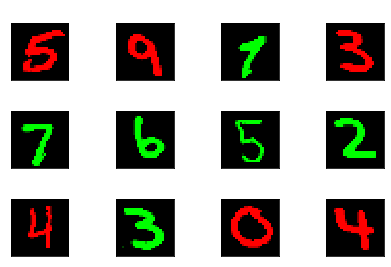

In [27]:
fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout() 
    img = train_1_dataset.__getitem__(i)[0]
    img = img.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    plt.imshow(img, interpolation='none')
    labels = train_1_dataset.__getitem__(i)[1]
    plt.title("Labels: {}".format(labels),color = 'white')
    plt.xticks([])
    plt.yticks([])
plt.show()

# 2. 定义模型

In [162]:
batch_size = 64
learning_rate = 0.01
momentum = 0.5
EPOCH = 50

In [163]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 10, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 20, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(320, 50),
            torch.nn.Linear(50, 2),
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  
        x = self.conv2(x)  
        x = x.view(batch_size, -1)  
        x = self.fc(x)
        return x

In [164]:
model = MyModel()

In [165]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum) 
# optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

# 3. 训练模型并输出测试结果

In [166]:
train_1_loader = DataLoader(new_train_1_dataset, batch_size=64, shuffle=True)
train_2_loader = DataLoader(new_train_2_dataset, batch_size=64, shuffle=True)
# train_all_loader = DataLoader(train_all_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [167]:
def train(epoch,train_loader):
    running_loss = 0.0  # 这整个epoch的loss清零
    running_total = 0
    running_correct = 0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target ,color= data
        optimizer.zero_grad()

        # forward + backward + update
        outputs = model(inputs)
        loss = criterion(outputs, target)
        # print(loss)

        loss.backward()
        optimizer.step()

        # 把运行中的loss累加起来，为了下面300次一除
        running_loss += loss.item()
        # 把运行中的准确率acc算出来
        _, predicted = torch.max(outputs.data, dim=1)
        running_total += inputs.shape[0]
        running_correct += (predicted == target).sum().item()

        if batch_idx % 60== 59:  # 不想要每一次都出loss，浪费时间，选择每300次出一个平均损失,和准确率
            print('[%d, %5d]: loss: %.3f , acc: %.2f %%'
                  % (epoch + 1, batch_idx + 1, running_loss / 300, 100 * running_correct / running_total))
            running_loss = 0.0  # 这小批300的loss清零
            running_total = 0
            running_correct = 0  # 这小批300的acc清零

In [168]:
def test():
    correct = 0
    total = 0
    with torch.no_grad():  # 测试集不用算梯度
        for data in test_loader:
            images, labels,color = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
            # print(predicted)
            total += labels.size(0)  # 张量之间的比较运算
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print('[%d / %d]: Accuracy on test set: %.1f %% ' % (epoch+1, EPOCH, 100 * acc))  # 求测试的准确率，正确数/总数
    return acc

train1上训练

In [244]:
if __name__ == '__main__':
    acc_list_test = []
    for epoch in range(EPOCH):
        train(epoch,train_1_loader)
        # train(epoch,train_2_loader)
        # if epoch % 10 == 9:  #每训练10轮 测试1次
        acc_test = test()
        acc_list_test.append(acc_test)

[1,    60]: loss: 0.131 , acc: 62.84 %
[1,   120]: loss: 0.127 , acc: 65.76 %
[1 / 50]: Accuracy on test set: 64.3 % 
[2,    60]: loss: 0.127 , acc: 65.96 %
[2,   120]: loss: 0.126 , acc: 66.90 %
[2 / 50]: Accuracy on test set: 66.8 % 
[3,    60]: loss: 0.127 , acc: 66.46 %
[3,   120]: loss: 0.124 , acc: 68.44 %
[3 / 50]: Accuracy on test set: 68.2 % 
[4,    60]: loss: 0.125 , acc: 67.99 %
[4,   120]: loss: 0.123 , acc: 68.96 %
[4 / 50]: Accuracy on test set: 68.5 % 
[5,    60]: loss: 0.123 , acc: 69.11 %
[5,   120]: loss: 0.122 , acc: 69.14 %
[5 / 50]: Accuracy on test set: 68.6 % 
[6,    60]: loss: 0.121 , acc: 70.10 %
[6,   120]: loss: 0.122 , acc: 69.79 %
[6 / 50]: Accuracy on test set: 70.5 % 
[7,    60]: loss: 0.121 , acc: 69.87 %
[7,   120]: loss: 0.119 , acc: 71.04 %
[7 / 50]: Accuracy on test set: 69.9 % 
[8,    60]: loss: 0.120 , acc: 70.36 %
[8,   120]: loss: 0.119 , acc: 70.73 %
[8 / 50]: Accuracy on test set: 72.2 % 
[9,    60]: loss: 0.118 , acc: 71.43 %
[9,   120]: loss:

train2上训练

In [36]:
if __name__ == '__main__':
    acc_list_test = []
    for epoch in range(EPOCH):
        # train(epoch,train_1_loader)
        train(epoch,train_2_loader)
        # if epoch % 10 == 9:  #每训练10轮 测试1次
        acc_test = test()
        acc_list_test.append(acc_test)

[1,    60]: loss: 0.138 , acc: 66.35 %
[1 / 50]: Accuracy on test set: 68.2 % 
[2,    60]: loss: 0.118 , acc: 71.20 %
[2 / 50]: Accuracy on test set: 68.0 % 
[3,    60]: loss: 0.113 , acc: 73.31 %
[3 / 50]: Accuracy on test set: 68.8 % 
[4,    60]: loss: 0.108 , acc: 74.48 %
[4 / 50]: Accuracy on test set: 68.3 % 
[5,    60]: loss: 0.105 , acc: 75.23 %
[5 / 50]: Accuracy on test set: 68.6 % 
[6,    60]: loss: 0.103 , acc: 76.02 %
[6 / 50]: Accuracy on test set: 68.3 % 
[7,    60]: loss: 0.100 , acc: 76.20 %
[7 / 50]: Accuracy on test set: 67.4 % 
[8,    60]: loss: 0.097 , acc: 77.29 %
[8 / 50]: Accuracy on test set: 69.6 % 
[9,    60]: loss: 0.096 , acc: 77.99 %
[9 / 50]: Accuracy on test set: 66.4 % 
[10,    60]: loss: 0.093 , acc: 78.80 %
[10 / 50]: Accuracy on test set: 69.5 % 
[11,    60]: loss: 0.092 , acc: 78.62 %
[11 / 50]: Accuracy on test set: 68.2 % 
[12,    60]: loss: 0.089 , acc: 80.16 %
[12 / 50]: Accuracy on test set: 66.8 % 
[13,    60]: loss: 0.086 , acc: 80.76 %
[13 / 

# ▶︎▶︎▶︎提高部分

### 1. 将上述过程中用到的神经网络替换为SNN，可使用SNNTorch库，并研究方法提高其泛化性能；


In [179]:
train_1_loader = DataLoader(new_train_1_dataset, batch_size=64, shuffle=True)
train_2_loader = DataLoader(new_train_2_dataset, batch_size=64, shuffle=True)
# train_all_loader = DataLoader(train_all_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [238]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn

# spike_grad = surrogate.atan()
spike_grad = surrogate.fast_sigmoid()
beta = 0.5
class SnnModel(nn.Module):
    def __init__(self):
        super(SnnModel, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 10, kernel_size=5),
            torch.nn.MaxPool2d(kernel_size=2),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 20, kernel_size=5),
            torch.nn.MaxPool2d(kernel_size=2),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True)
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(320, 50),
            torch.nn.Linear(50, 2),
            # snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
        )

    def forward(self, x):
        utils.reset(self.conv1)
        utils.reset(self.conv2)
        utils.reset(self.fc)
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.conv2(x)  
        x = x.view(batch_size, -1)  
        x = self.fc(x)
            # spk_out, mem_out = net(data)
            # spk_rec.append(spk_out)
            # spk_rec.append(x)
        return x
        # return torch.stack(spk_rec)

snnmodel = SnnModel()
snn_optimizer = torch.optim.Adam(snnmodel.parameters(), lr=2e-3, betas=(0.9, 0.999))
# snn_loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

snn_criterion = torch.nn.CrossEntropyLoss()

In [242]:
def train_snn(epoch,train_loader):
    running_loss = 0.0  # 这整个epoch的loss清零
    running_total = 0
    running_correct = 0
    for batch_idx, data in enumerate(train_loader, 0):
        inputs, target ,color= data
        snn_optimizer.zero_grad()
        # print(inputs.shape)

        # forward + backward + update
        outputs = snnmodel(inputs)
        # outputs = torch.tensor(outputs)
        # print(len(outputs))
        # print(outputs[1])
        # print(outputs.shape)
        # print(type(outputs))
        # print(outputs)
        # loss = snn_loss_fn(outputs,target)
        loss = snn_criterion(outputs, target)
        # print(loss)

        loss.backward()
        snn_optimizer.step()

        # 把运行中的loss累加起来，为了下面300次一除
        running_loss += loss.item()
        # 把运行中的准确率acc算出来
        _, predicted = torch.max(outputs.data, dim=1)
        running_total += inputs.shape[0]
        running_correct += (predicted == target).sum().item()

        if batch_idx % 60== 59:  # 不想要每一次都出loss，浪费时间，选择每300次出一个平均损失,和准确率
            print('[%d, %5d]: loss: %.3f , acc: %.2f %%'
                  % (epoch + 1, batch_idx + 1, running_loss / 300, 100 * running_correct / running_total))
            running_loss = 0.0  # 这小批300的loss清零
            running_total = 0
            running_correct = 0  # 这小批300的acc清零

In [240]:
def test_snn():
    correct = 0
    total = 0
    with torch.no_grad():  # 测试集不用算梯度
        for data in test_loader:
            images, labels,color = data
            outputs = snnmodel(images)
            _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
            # print(predicted)
            total += labels.size(0)  # 张量之间的比较运算
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print('[%d / %d]: Accuracy on test set: %.1f %% ' % (epoch+1, EPOCH, 100 * acc))  # 求测试的准确率，正确数/总数
    return acc

In [243]:
if __name__ == '__main__':
    acc_list_test = []
    for epoch in range(EPOCH):
        train_snn(epoch,train_1_loader)
        # train(epoch,train_2_loader)
        # if epoch % 10 == 9:  #每训练10轮 测试1次
        acc_test = test_snn()
        acc_list_test.append(acc_test)

[1,    60]: loss: 0.125 , acc: 66.85 %
[1,   120]: loss: 0.128 , acc: 66.38 %
[1 / 50]: Accuracy on test set: 66.6 % 
[2,    60]: loss: 0.127 , acc: 66.43 %
[2,   120]: loss: 0.125 , acc: 68.12 %
[2 / 50]: Accuracy on test set: 69.8 % 
[3,    60]: loss: 0.124 , acc: 69.06 %
[3,   120]: loss: 0.123 , acc: 69.38 %
[3 / 50]: Accuracy on test set: 70.4 % 
[4,    60]: loss: 0.122 , acc: 68.75 %
[4,   120]: loss: 0.124 , acc: 68.98 %
[4 / 50]: Accuracy on test set: 71.7 % 
[5,    60]: loss: 0.123 , acc: 68.62 %
[5,   120]: loss: 0.124 , acc: 68.52 %
[5 / 50]: Accuracy on test set: 67.3 % 
[6,    60]: loss: 0.123 , acc: 68.91 %
[6,   120]: loss: 0.122 , acc: 68.91 %
[6 / 50]: Accuracy on test set: 69.3 % 
[7,    60]: loss: 0.121 , acc: 69.64 %
[7,   120]: loss: 0.122 , acc: 69.11 %
[7 / 50]: Accuracy on test set: 67.6 % 
[8,    60]: loss: 0.122 , acc: 68.80 %
[8,   120]: loss: 0.121 , acc: 69.90 %
[8 / 50]: Accuracy on test set: 71.6 % 
[9,    60]: loss: 0.123 , acc: 68.36 %
[9,   120]: loss:

### 2. 将上述过程中用到的神经网络替换为Memristor，可使用MemTorch库，并研究方法提高其泛化性能；

### 3. 进一步研究因果推理，因果表示学习方法，甚至不限于这类方法，提高卷积神经网络在此数据集上的性能。